In [1]:
# 项目的 脚本 在 /root/GanLuo/ICML2025_project/scripts_pushpull/run_push_pull_track_grad_norm.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

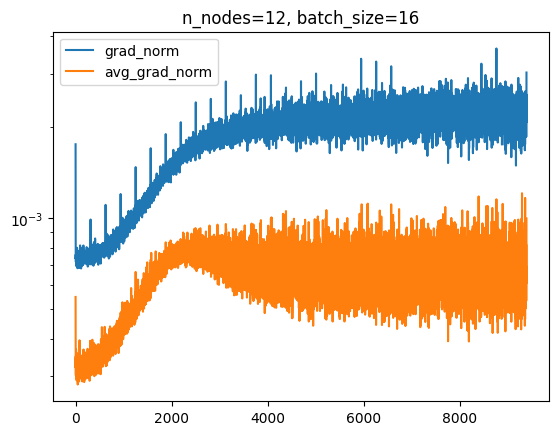

In [2]:
df4 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=12, batch_size=16, 2025-03-22.csv")
plt.semilogy(df4["grad_norm"], label="grad_norm")
plt.semilogy(df4["avg_grad_norm"], label="avg_grad_norm")
plt.title("n_nodes=12, batch_size=16")
plt.legend()
plt.show()

In [ ]:
df1 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=2, batch_size=128, 2025-03-22.csv")
df2 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=4, batch_size=128, 2025-03-22.csv")
df3 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=8, batch_size=128, 2025-03-22.csv")
df4 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=16, batch_size=128, 2025-03-22.csv")

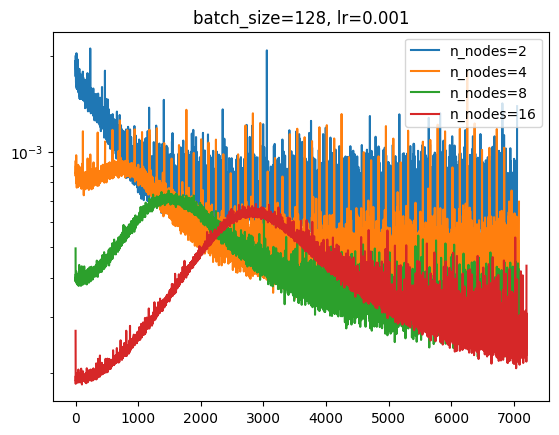

In [16]:
df1 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=2, batch_size=128, 2025-03-22.csv")
df2 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=4, batch_size=128, 2025-03-22.csv")
df3 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=8, batch_size=128, 2025-03-22.csv")
df4 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=16, batch_size=128, 2025-03-22.csv")
a = "avg_grad_norm"

plt.semilogy(df1[a], label="n_nodes=2")
plt.semilogy(df2[a], label="n_nodes=4")
plt.semilogy(df3[a], label="n_nodes=8")
plt.semilogy(df4[a], label="n_nodes=16")
plt.title("batch_size=128, lr=0.001")
plt.legend()
plt.show()

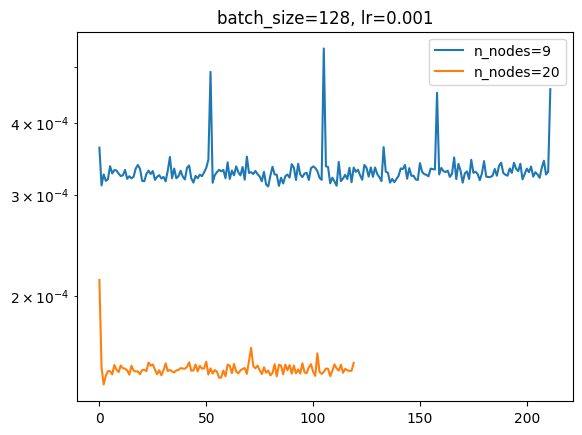

In [6]:
df1 = pd.read_csv("/root/GanLuo/ICML2025_project/PUSHPULL_PROJECT/real_data_track_grad_norm/output/grad_norm_TEST_Exp_test, PushPull, lr=0.001, n_nodes=9, batch_size=128, 2025-03-22.csv")
df2 = pd.read_csv("/root/GanLuo/ICML2025_project/PUSHPULL_PROJECT/real_data_track_grad_norm/output/grad_norm_TEST_Exp_test, PushPull, lr=0.001, n_nodes=20, batch_size=128, 2025-03-22.csv")

a = "avg_grad_norm"

plt.semilogy(df1[a], label="n_nodes=9")
plt.semilogy(df2[a], label="n_nodes=20")
plt.title("batch_size=128, lr=0.001")
plt.legend()
plt.show()

In [10]:
import torch
import torch.nn as nn
import numpy as np
from typing import List

# 定义一个简单的全连接网络作为测试模型
class SimpleFCN(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        super(SimpleFCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 你提供的 compute_avg_gradient_matrix_norm 函数
def compute_avg_gradient_matrix_norm(model_list):
    num_params = sum(p.numel() for p in model_list[0].parameters() if p.grad is not None)
    num_models = len(model_list)
    
    all_grads = torch.zeros(num_models, num_params)
    
    for i, model in enumerate(model_list):
        grads = [param.grad.view(-1) for param in model.parameters() if param.grad is not None]
        if grads:
            grad_vector = torch.cat(grads)
            all_grads[i] = grad_vector
    
    avg_grad = all_grads.mean(dim=0)
    avg_norm = avg_grad.norm(2) / (num_params ** 0.5)
    
    return avg_norm.item()

# 实验测试函数
def test_avg_gradient_norm_scaling(
    num_models_list: List[int] = [2, 5, 10, 20, 50],
    input_dim: int = 784,
    hidden_dim: int = 128,
    output_dim: int = 10,
    grad_scale: float = 1.0,
    seed: int = 42
):
    """
    测试 compute_avg_gradient_matrix_norm 在不同 num_models 下的量级稳定性。
    
    Args:
        num_models_list (List[int]): 要测试的模型数量列表
        input_dim (int): 模型输入维度
        hidden_dim (int): 模型隐藏层维度
        output_dim (int): 模型输出维度
        grad_scale (float): 梯度幅值缩放因子，用于控制模拟梯度的大小
        seed (int): 随机种子，确保结果可重复
    
    Returns:
        dict: 包含每个 num_models 对应的 avg_norm 结果
    """
    # 设置随机种子
    torch.manual_seed(seed)
    np.random.seed(seed)

    # 创建一个基准模型以获取参数数量
    base_model = SimpleFCN(input_dim, hidden_dim, output_dim)
    num_params = sum(p.numel() for p in base_model.parameters())
    print(f"Single model parameter count: {num_params}")

    # 存储结果
    results = {}

    # 对每个 num_models 进行测试
    for num_models in num_models_list:
        print(f"\nTesting with num_models = {num_models}")
        
        # 创建模型列表
        model_list = [SimpleFCN(input_dim, hidden_dim, output_dim) for _ in range(num_models)]
        
        # 为每个模型生成模拟梯度
        for model in model_list:
            for param in model.parameters():
                # 生成随机梯度，均值约为 0，方差受 grad_scale 控制
                param.grad = torch.randn_like(param) * grad_scale
        
        # 计算 avg_norm
        avg_norm = compute_avg_gradient_matrix_norm(model_list)
        
        # 额外计算单个模型的梯度范数作为参考
        single_grad_norms = [
            torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None]).norm(2).item()
            / (num_params ** 0.5)
            for model in model_list
        ]
        
        # 记录结果
        results[num_models] = {
            "avg_norm": avg_norm,
            "single_grad_norms_mean": np.mean(single_grad_norms),
            "single_grad_norms_std": np.std(single_grad_norms)
        }
        
        # 打印中间结果
        print(f"avg_norm: {avg_norm:.6f}")
        print(f"Mean of single model grad norms: {results[num_models]['single_grad_norms_mean']:.6f}")
        print(f"Std of single model grad norms: {results[num_models]['single_grad_norms_std']:.6f}")

    # 输出总结
    print("\nSummary of avg_norm across num_models:")
    for num_models, data in results.items():
        print(f"num_models={num_models}: avg_norm={data['avg_norm']:.6f}")

    return results

# 运行测试
if __name__ == "__main__":
    # 测试不同模型数量
    num_models_list = [2, 5, 10, 20, 50, 100, 200, 500]
    results = test_avg_gradient_norm_scaling(
        num_models_list=num_models_list,
        grad_scale=0.1,  # 设置较小的梯度幅值，便于观察
        seed=42
    )

Single model parameter count: 101770

Testing with num_models = 2
avg_norm: 0.070712
Mean of single model grad norms: 0.099989
Std of single model grad norms: 0.000036

Testing with num_models = 5
avg_norm: 0.044742
Mean of single model grad norms: 0.100070
Std of single model grad norms: 0.000320

Testing with num_models = 10
avg_norm: 0.031547
Mean of single model grad norms: 0.100000
Std of single model grad norms: 0.000196

Testing with num_models = 20
avg_norm: 0.022362
Mean of single model grad norms: 0.100035
Std of single model grad norms: 0.000175

Testing with num_models = 50
avg_norm: 0.014144
Mean of single model grad norms: 0.099979
Std of single model grad norms: 0.000255

Testing with num_models = 100
avg_norm: 0.010025
Mean of single model grad norms: 0.100010
Std of single model grad norms: 0.000220

Testing with num_models = 200
avg_norm: 0.007067
Mean of single model grad norms: 0.100027
Std of single model grad norms: 0.000214

Testing with num_models = 500
avg_norm